In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Read in the Dataset

In [2]:
image_shape = (224, 224, 3)

dataset = tf.keras.utils.image_dataset_from_directory(
    directory="dataset/v3",
    image_size=image_shape[:2],
)

x, y = [], []
for batch in dataset.take(-1):
    images, labels = batch
    x.append(images.numpy())
    y.append(labels.numpy())

x = np.concatenate(x)
y = np.concatenate(y)

Found 3080 files belonging to 10 classes.


In [3]:
dataset.class_names

['Acral Lentiginous Melanoma',
 'Beaus Line',
 'Blue Finger',
 'Clubbing',
 'Healthy Nail',
 'Koilonychia',
 'Muehrckes Lines',
 'Onychogryphosis',
 'Pitting',
 'Terry-s Nail']

## Split into Train/Validation/Test at 80/10/10 Ratio

In [4]:
class_names = dataset.class_names
num_classes = len(class_names)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)

In [5]:
print(
    f"total  : {np.unique(y, return_counts=True)[1]}\n"
    f"y_train: {np.unique(y_train, return_counts=True)[1]}\n"
    f"y_val  : {np.unique(y_val, return_counts=True)[1]}\n"
    f"y_test : {np.unique(y_test, return_counts=True)[1]}"
)

total  : [357 218 292 373 358 260 159 329 312 422]
y_train: [286 174 234 298 286 208 127 263 250 338]
y_val  : [36 22 29 37 36 26 16 33 31 42]
y_test : [35 22 29 38 36 26 16 33 31 42]


## Define Helpers

In [6]:
def plot_loss_and_accuracy(history) -> None:
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title("Loss")
    ax1.plot(history.history["loss"], label="Train")
    ax1.plot(history.history["val_loss"], label="Validation")
    ax1.legend(loc="best")

    ax2.set_title("Accuracy")
    ax2.plot(history.history["accuracy"], label="Train")
    ax2.plot(history.history["val_accuracy"], label="Validation")
    ax2.legend(loc="best")

    plt.show()

## Data Augmentation

In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,  # degree
    horizontal_flip=True,
    vertical_flip=True,
)

datagen.fit(x_train)

## Train and Evaluate

In [8]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=image_shape, include_top=False)

base_model.trainable = False

In [9]:
inputs = tf.keras.Input(shape=image_shape)

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-4)

model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
batch_size = 4
epochs = 5

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                    validation_data=(x_val, y_val))

Epoch 1/5
616/616 [==============================] - 30s 39ms/step - loss: 1.5590 - accuracy: 0.4724 - val_loss: 1.0247 - val_accuracy: 0.6494
Epoch 2/5
616/616 [==============================] - 22s 35ms/step - loss: 0.9421 - accuracy: 0.7021 - val_loss: 0.8135 - val_accuracy: 0.7403
Epoch 3/5
616/616 [==============================] - 22s 36ms/step - loss: 0.7717 - accuracy: 0.7557 - val_loss: 0.7169 - val_accuracy: 0.7435
Epoch 4/5
616/616 [==============================] - 23s 37ms/step - loss: 0.6752 - accuracy: 0.7918 - val_loss: 0.6440 - val_accuracy: 0.7922
Epoch 5/5
616/616 [==============================] - 25s 40ms/step - loss: 0.5859 - accuracy: 0.8141 - val_loss: 0.5939 - val_accuracy: 0.7922


loss=0.7345, accuracy=0.7468


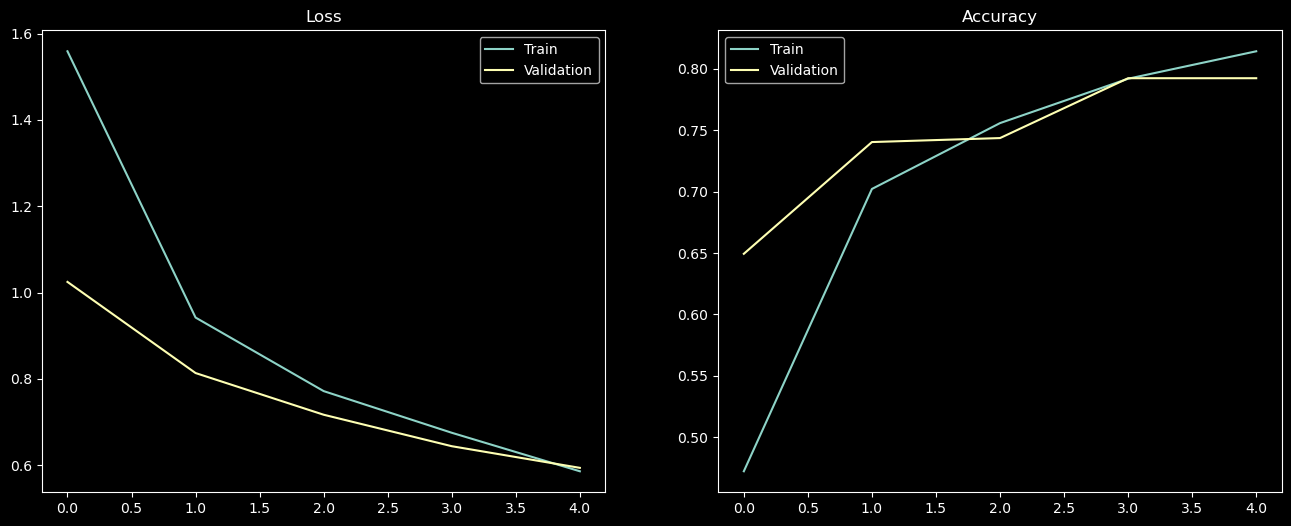

In [12]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print(f"{loss=:.4f}, {accuracy=:.4f}")
plot_loss_and_accuracy(history)

## Predict

In [13]:
def make_prediction(image):
    predictions = model.predict(np.expand_dims(image, axis=0), verbose=0)
    [pred] = predictions
    for index in pred.argsort()[::-1]:
        print(f"{pred[index] * 100:5.2f}% - {class_names[index]}")
    plt.imshow(image.astype("uint8"))

66.27% - Clubbing
17.10% - Beaus Line
10.87% - Muehrckes Lines
 3.44% - Onychogryphosis
 0.82% - Acral Lentiginous Melanoma
 0.63% - Blue Finger
 0.55% - Terry-s Nail
 0.23% - Pitting
 0.05% - Koilonychia
 0.03% - Healthy Nail


(None, 'Clubbing')

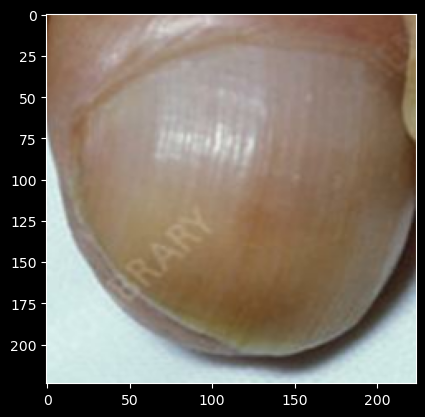

In [20]:
i = 69
make_prediction(x_test[i]), class_names[y_test[i]]